In [115]:
def make_simpson(group_sample_size = 200,
                 group_linear_coef = 1,
                 group_error_std = 1,
                 group_mean = 1,
                 var_names = ['x','y','group'],
                 shuffle = False):
  

  '''
  Simulates data illustrating Simpson's paradox

  Parameters
  ----------

  group_sample_size: int
    The number of points in each group.
    Since there are two groups, the total number of points will be two times this parameter.
  
  group_linear_coef: float
    The slope of the regression line in each group.
    This value is the same for both groups.

  group_error_std: float
    The standard deviation of the error term in each group.
  
  group_mean: float
    The mean value of X in group 1.
    The mean value of x in group 2 will be the opposite of this value.
  
  var_names: list
    A list of 3 strings containing the column names of the dataframe to be returned.
    In other words, a list containing the name of the independent variable, 
    the name of the dependent variable, and the name of the variable that distinguishes both groups
    and whose omission or inclusion gives rise to the Simpson's paradox.

  shuffle: bool
    If True, rows in the generated dataset will be randomly shuffled.

  
  Returns:
  --------
  pandas dataframe
    A pandas dataframe.
  
  Notes:
  ------

  This function generates a pandas dataframe with data belonging to two groups.
  Running a linear regression in each group separately 
  yields a slope which is opposite to the slope obtained by running a regression
  in each group separately. Thus, if the slope in each group is +1 (default),
  the slope in the overall group will be approximately -1 (this relationship
  is exact when group_error_std = 0)

  This code generates data with the following characteristics:
  (1) two groups of equal size
  (2) equal regression slopes for each group
  (3) Sum of the values of X in one group is opposite to that in the other group
  (4) Sum of the squared values of X in both groups are equal
  (5) Intercept in one group is opposite the intercept in the other group

  Under these assumptions, it can be shown that the overall intercept equals

  intercept of group 1 * Sx/Sxx + slope of group 1

  where Sx = (Sum of X in group 1) and Sxx = (Sum of X squared in group 1)

  Hence, the overall slope will be opposite to the slope in each group when the
  intercept of group 1 is

  -2 * slope of group 1 * Sxx/Sx

  Thus, except for a random error term, the equations of the groups are

  (Group 1) y = -2 * slope of group 1 * Sxx/Sx + slope of group 1 * x
  (Group 2) y = +2 * slope of group 1 * Sxx/Sx + slope of group 1 * x

  and the equation of the regression line for the entire dataset is

  y = -1 * slope of group 1 * x

  with zero intercept.

  The presence of an error term will weaken this relationship.
  Particularly for high values of group_error_std and small individual slopes, 
  the slope of the overall slope may deviate substantially 
  from the opposite of the slope of the individual groups.

  However, some error term may still be beneficial to illustrate a situation
  where Simpson's paradox cannot be obviously dismissed simply by looking at
  a scatterplot of the data.

  Of course, once the data is generated, it can be translated to any desired intercept
  and average value of X.

  '''
  
  import numpy as np
  import pandas as pd
  
  #Generate values for x in each group
  x1 = np.random.normal(loc = group_mean, scale = 1, size = group_sample_size)
  x2 = -x1

  #Calculate sum of x in each group (they're the same)
  Sx = x1.sum()

  #Calculate sum of x**2 in each group (they're the same)
  Sxx = (x1**2).sum()

  #Generate random error terms for each group
  e1 = np.random.normal(loc = 0, scale = group_error_std, size = group_sample_size)
  e2 = np.random.normal(loc = 0, scale = group_error_std, size = group_sample_size)

  #Calculate value of intercept for each group
  intercept1 = -2 * Sxx / Sx * group_linear_coef
  intercept2 = -1 * intercept1 

  #Calculate value of y for each group
  y1 = intercept1 + group_linear_coef * x1 + e1
  y2 = intercept2 + group_linear_coef * x2 + e2

  #Put everything into a pandas dataframe
  df1 = pd.DataFrame({'x':x1, 'y':y1, 'group': 1})
  df2 = pd.DataFrame({'x':x2, 'y':y2, 'group': 2})
  df = pd.concat([df1, df2])
  df.columns = var_names

  if shuffle:
    #Shuffle rows randomly
    df=df.sample(frac=1)
 

  return(df)


df = make_simpson(group_linear_coef = 1, group_error_std = 1)
df

,x,y,group
0,0.504584,-2.584547,1
1,0.575427,-4.388554,1
2,1.144132,-0.210186,1
3,1.868556,-0.204079,1
4,0.747793,-3.155394,1
...,...,...,...
195,-2.218982,-0.085082,2
196,0.432158,5.290949,2
197,-0.065391,4.829847,2
198,-0.792933,2.530372,2


{'group_1': array([[1.01036753]]),
 'group_2': array([[1.112198]]),
 'overall': array([[-0.92418597]])}

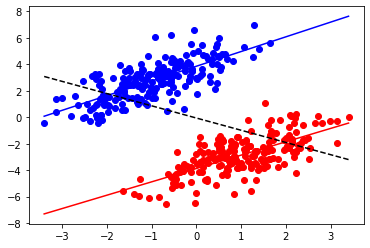

In [116]:
def simpson_slopes(df, plot=False):

  ''' 
  Calculates the slopes of the regression line in each group and on the entire dataset

  Parameters:
  -----------

  df: Dataframe
    A dataframe generated by function make_simpson
  
  plot: bool
    If True, plots the regression lines for each group and for the entire dataset
  
  '''

  import pandas as pd
  import numpy as np
  from sklearn.linear_model import LinearRegression

  df.columns = ['x','y','group']

  def prepare_array(col, group, df = df):

    array = (df.
             loc[df.group == group, col].
             to_numpy().
             reshape(-1,1)
    )
    return(array)

  x1 = prepare_array('x',1)
  y1 = prepare_array('y',1)
  x2 = prepare_array('x',2)
  y2 = prepare_array('y',2)

  x3 = np.concatenate([x1, x2])
  y3 = np.concatenate([y1, y2])

  linreg1 = LinearRegression().fit(x1, y1)
  linreg2 = LinearRegression().fit(x2, y2)
  linreg3 = LinearRegression().fit(x3, y3)

  output = {'group_1': linreg1.coef_,
            'group_2': linreg2.coef_,
            'overall': linreg3.coef_
            }

  if plot:

    import matplotlib.pyplot as plt
    plt.scatter(x1, y1, c='red')
    plt.scatter(x2, y2, c='blue')
    domain = np.linspace(min(x3), max(x3))
    plt.plot(domain, linreg1.intercept_ + linreg1.coef_ * domain, c='red')
    plt.plot(domain, linreg2.intercept_ + linreg2.coef_ * domain, c='blue')
    plt.plot(domain, linreg3.intercept_ + linreg3.coef_ * domain, c='black', linestyle='dashed')

  
  return(output)

simpson_slopes(df, plot=True)



